In [82]:
import numpy as np 
from scipy.optimize import minimize 
from scipy import linalg 
import matplotlib.pyplot as plt
import random
%matplotlib inline

# np.random.seed(0) 
N = 100 
half_n = N//2 
r = 10 
s = r/16 
t = np.random.uniform(0, 2*np.pi, half_n) 
n = s*np.random.randn(half_n) 
x1 , y1 = (r + n)*np.cos(t), (r + n)*np.sin(t) 
X_circ = np.hstack((x1.reshape(half_n, 1) , y1.reshape(half_n , 1))) 

m, b = -1, 2 
x2 = np.linspace(-12, 12 , half_n) 
y2 = m*x2 + b + s*np.random.randn(half_n) 
X_line = np.hstack((x2.reshape(half_n , 1) , y2.reshape(half_n , 1))) 
X = np.vstack((X_circ , X_line))
y=y1 + y2


In [83]:
class RANSAC:
    def __init__(self,x_data,y_data,min_samples,dis_thres,num_samps):
        self.x_data=x_data
        self.y_data=y_data
        self.s=min_samples
        self.t=dis_thres
        self.N=num_samps
        self.best_model=None
        self.inliers=[]
        self.outliers=[]
        self.points=[]

    def distance(self,p1,p2):
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5

    def random_sample(self):
        self.points=[]
        i=0
        while i<self.s:
            ind=random.randint(0,len(self.x_data)-1)
            pnt=(self.x_data[ind],self.y_data[ind])
            if pnt not in self.points:
                self.points.append(pnt)
                i+=1

    def circle_equation(self):
        pt1,pt2,pt3=self.points
        Y = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        Z = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
        inverse_Y = linalg.inv(Y)
        c_x, c_y = np.dot(inverse_Y, Z) / 2
        cx, cy = c_x[0], c_y[0]
        r = np.sqrt((cx - pt1[0])**2 + (cy - pt1[1])**2)
        return cx, cy, r

    def inliers_filter(self):
        new_inliers=[]
        new_outliers=[]
        xc,yc,r=self.circle_equation()
        for i in range(len(self.x_data)):
            dist=self.distance((self.x_data[i],self.y_data[i]),(xc,yc))
            if abs(dist-r)<=self.t:
                new_inliers.append((self.x_data[i],self.y_data[i]))
            else:
                new_outliers.append((self.x_data[i],self.y_data[i]))
            
        if len(self.inliers)<len(new_inliers):
            self.inliers=new_inliers
            self.outliers=new_outliers
            self.best_model=(xc,yc,r)

    def model_finder(self):
        for i in range(self.N):
            self.random_sample()
            self.inliers_filter()

        return self.best_model
    
    

In [84]:
best_samp=RANSAC(X[:,0],X[:,1],3,1,35)
best_samp.model_finder()

(0.4888455144919101, -0.09431272130057618, 10.120053018309031)

In [85]:
ransac=RANSAC(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],3,1,35)
ransac.model_finder()

(0.17803075168441465, 0.32455742097881046, 10.156075710439708)

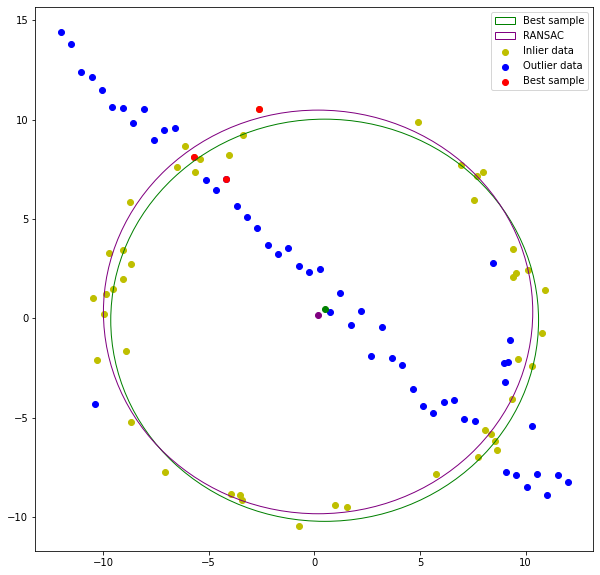

In [87]:
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],c='y',label='Inlier data')
ax.scatter(np.array(best_samp.outliers)[:,0],np.array(best_samp.outliers)[:,1],c='b',label='Outlier data')

circle1 = plt.Circle((best_samp.best_model[0], best_samp.best_model[1]), best_samp.best_model[2], color='green',fill=False,label='Best sample')
ax.add_patch(circle1)

circle2 = plt.Circle((ransac.best_model[0], ransac.best_model[1]), ransac.best_model[2], color='purple',fill=False,label='RANSAC')
ax.add_patch(circle2)

ax.scatter(np.array(best_samp.points)[:,0],np.array(best_samp.points)[:,1],c='r',label='Best sample')
ax.scatter(best_samp.best_model[0],best_samp.best_model[0],c='green')
ax.scatter(ransac.best_model[0],ransac.best_model[0],c='purple')
ax.legend(loc='upper right')
plt.show()

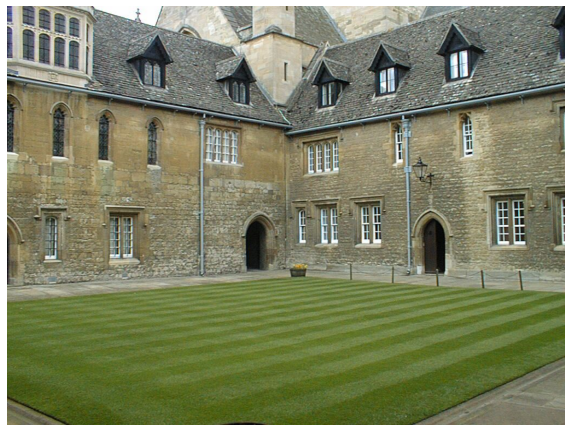

In [31]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_coord(image_name):
    img = cv.imread(image_name, 1)
    dst_points=[]
    def click_event(event, x, y, flags, params):
        global img
        if event==cv.EVENT_LBUTTONDOWN:
            dst_points.append((x,y))
            img = cv2.circle(img, (x,y), 2, [0,0,255], 2)
            cv.imshow('image', img)

    return dst_points

img_hall=cv.imread(r'hall.jpg',cv.IMREAD_COLOR)
assert img_hall is not None
img_flag=cv.imread(r'sri lankan flag.png',cv.IMREAD_COLOR)
assert img_flag is not None

def homography(img_fg,img_bg):
    theta=np.pi*10/180
    s=0.7
    tx,ty=15,25
    H=np.array([[s*np.cos(theta),-s*np.sin(theta),tx],[s*np.sin(theta),s*np.cos(theta),ty],[0,0,1]])

    img_nf=img_flag.copy()
    for i in range(len(img_flag)):
        for j in range(len(img_flag[0])):
            img_nf[i][j]=H@np.array(img_flag[i][j])

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
#ax.imshow(cv.cvtColor(img_nf, cv.COLOR_BGR2RGB),alpha=0.5)

# x=np.append(Y[0,:],Y[0,0])
# y=np.append(Y[1,:],Y[1,0])

# ax.plot(x,y,color='r')
ax.set_aspect('equal')
ax.axis('off')
plt.show()

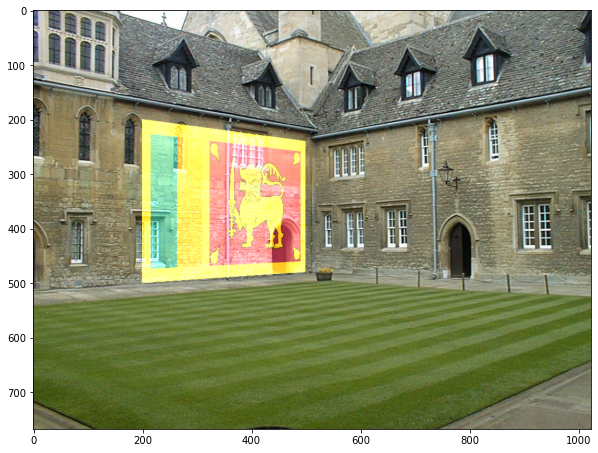

In [14]:
pts_src = np.array([[0, 0], [0, 400], [800, 0],[800, 400]])
pts_dst = np.array([[200, 200], [200,500], [500,240],[500,480]])
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(img_flag, h, (img_hall.shape[1],img_hall.shape[0]))

fig,ax=plt.subplots(1,1,figsize=(10,10))
#ax.imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
ax.imshow(cv.cvtColor(cv.add(img_hall,im_out), cv.COLOR_BGR2RGB))

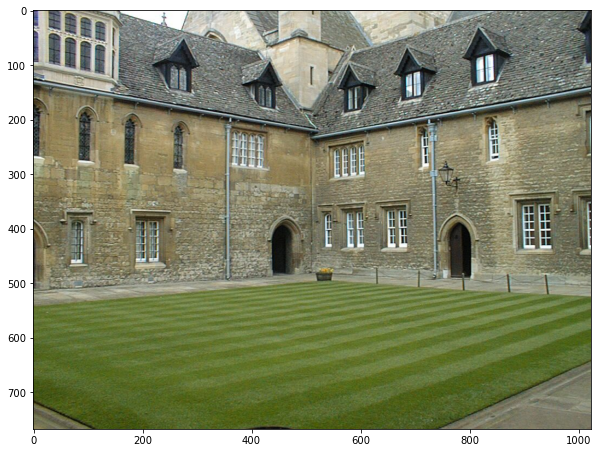

In [19]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_coord():
    img = cv.imread('hall.jpg', 1)
    dst_points=[]
    def click_event(event, x, y, flags, params):
        global img
        if event==cv.EVENT_LBUTTONDOWN:
            dst_points.append((x,y))
            img = cv2.circle(img, (x,y), 2, [0,0,255], 2)
            cv.imshow('image', img)

cv.imshow('image', img)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()
print(dst_points)
img_hall=cv.imread(r'hall.jpg',cv.IMREAD_COLOR)
assert img_hall is not None
img_flag=cv.imread(r'gohome gota.jpg',cv.IMREAD_COLOR)
assert img_flag is not None


theta=np.pi*10/180
s=0.7
tx,ty=15,25
H=np.array([[s*np.cos(theta),-s*np.sin(theta),tx],[s*np.sin(theta),s*np.cos(theta),ty],[0,0,1]])

img_nf=img_flag.copy()
for i in range(len(img_flag)):
    for j in range(len(img_flag[0])):
        img_nf[i][j]=H@np.array(img_flag[i][j])


fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
#ax.imshow(cv.cvtColor(img_nf, cv.COLOR_BGR2RGB),alpha=0.5)

# x=np.append(Y[0,:],Y[0,0])
# y=np.append(Y[1,:],Y[1,0])

# ax.plot(x,y,color='r')
ax.set_aspect('equal')
plt.show()

In [20]:
img_flag.shape

(1081, 1080, 3)

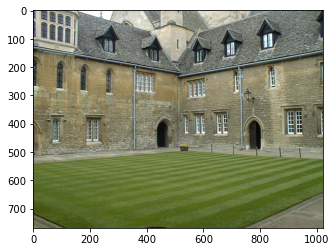

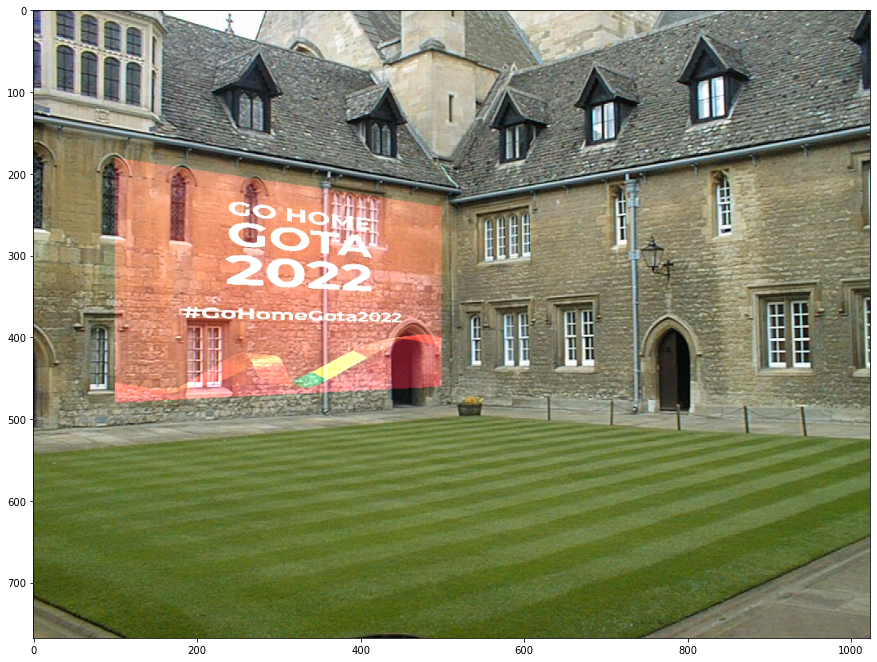

In [27]:
pts_src = np.array([[0, 0], [0, 1081], [1080, 0],[1080, 1081]])
pts_dst = np.array([[100, 180], [100,480], [500,240],[500,460]])
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(img_flag, h, (img_hall.shape[1],img_hall.shape[0]))
fig=plt.figure()
plt.imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)

fig,ax=plt.subplots(1,1,figsize=(15,15))

#ax.imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
ax.imshow(cv.cvtColor(cv.add(img_hall,im_out), cv.COLOR_BGR2RGB))

In [40]:
img = cv.imread('hall.jpg', 1)
dst_points=[]
def click_event(event, x, y, flags, params):
	global img
	if event==cv.EVENT_LBUTTONDOWN:
		dst_points.append((x,y))
		img = cv2.circle(img, (x,y), 2, [0,0,255], 2)
		cv.imshow('image', img)

cv.imshow('image', img)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()
print(dst_points)

[(223, 189), (224, 487), (507, 473), (507, 234)]
